### Import packages

In [1]:
import pandas as pd
from keras.models import Model, Sequential, model_from_json,load_model
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.preprocessing.image import load_img, save_img, img_to_array,ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.callbacks import History, EarlyStopping
import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from scipy.misc import imresize
import os
import PIL
from skimage.transform import resize
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle
from lime import lime_image
import lime
from skimage.segmentation import mark_boundaries
import imageio
plt.style.use('ggplot')
from datetime import datetime as dt
import category_encoders as ce
from sklearn.model_selection import train_test_split as TTS
from sklearn.linear_model import LinearRegression as LinR, LogisticRegression as LogR
from sklearn.metrics import roc_curve, auc,accuracy_score, confusion_matrix, roc_auc_score, precision_recall_curve, classification_report
from sklearn import metrics
from sklearn.model_selection import KFold,GridSearchCV as GSCV, RandomizedSearchCV as RSCV
from sklearn.ensemble import RandomForestClassifier as RFC,RandomForestRegressor as RFR
import sklearn.model_selection

Using TensorFlow backend.


In [2]:
def do_auc_prec_recall(y_actual,y_pred,show_confusion):
    """Displays Precision, Recall, AUC, Accuracy vs. Threshold"""
    precision, recall, thresholds = precision_recall_curve(y_actual, y_pred) 
    pr_auc = metrics.auc(recall, precision)
    plt.plot(thresholds, precision[: -1], "b--", label="Precision")
    plt.plot(thresholds, recall[: -1], "r--", label="Recall")
    plt.legend(loc="lower left")
    plt.ylim([0,1])
    pred_proba_df = pd.DataFrame(y_pred)
    threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,.55,.6,.65,.7,.75,.8,.85] 
    aucs = []
    accs = []
    for i in threshold_list:
        
        Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
        accuracy = metrics.accuracy_score(y_actual, Y_test_pred)
        auc = metrics.roc_auc_score(y_actual, Y_test_pred)
        aucs.append(auc)
        accs.append(accuracy)
        if show_confusion == 1:
            print ('******** For i = {} ******'.format(i))
            print(confusion_matrix(y_actual,Y_test_pred))
    plt.plot(threshold_list,aucs,marker='o',color='r')
    plt.plot(threshold_list,accs,marker='o',color='b')
    plt.legend(['AUC','Accuracy'])
    plt.xlabel('Threshold')
    plt.ylabel('Metric')
    plt.legend(['Precision','Recall','AUC','Accuracy'])


def get_metrics(mod,Xtrain,Xtest,ytrain,ytest,thresh):
    """Display ROC AUC and confusion matrix for input model"""
    
    #Training SET
    print('TRAINING SET')
    y_pred2 = mod.predict_proba(Xtrain)[:,1]
    print('AUC = ' , roc_auc_score(ytrain, y_pred2))
    y_pred2[y_pred2>thresh]=1
    y_pred2[y_pred2<1]=0
    print(confusion_matrix(ytrain,y_pred2))

    #TESTING SET
    print('TEST SET')
    y_pred2 = mod.predict_proba(Xtest)[:,1]
    print('AUC = ' , roc_auc_score(ytest, y_pred2))
    y_pred2[y_pred2>thresh]=1
    y_pred2[y_pred2<1]=0
    print(confusion_matrix(ytest,y_pred2))    
    return 

def my_makedir(path):
    """If a directory, does not exist, create it."""
    if not os.path.exists(path):
        os.makedirs(path)
    return path

In [3]:
file_users = 'takehome_users.csv'
file_actions = 'takehome_user_engagement.csv'
users = pd.read_csv(file_users,header=0,parse_dates=True, encoding='latin1',index_col=0)
users.head(3)

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(3), object(4)
memory usage: 937.5+ KB


In [5]:
# Set time nulls to 0
users.loc[users.last_session_creation_time.isnull(),'last_session_creation_time']=0
users.loc[users.creation_time.isnull(),'creation_time']=0

In [6]:
# Create datetime column
users['last_session_creation_time2'] = pd.to_datetime(users.last_session_creation_time,unit='s')

In [7]:
# Create datetime column
users['creation_time2'] = pd.to_datetime(users.creation_time,format ='%Y-%m-%d %H:%M:%S')

In [8]:
users = users.drop('creation_time',axis=1).drop('last_session_creation_time',axis=1)

In [9]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
name                           12000 non-null object
email                          12000 non-null object
creation_source                12000 non-null object
opted_in_to_mailing_list       12000 non-null int64
enabled_for_marketing_drip     12000 non-null int64
org_id                         12000 non-null int64
invited_by_user_id             6417 non-null float64
last_session_creation_time2    12000 non-null datetime64[ns]
creation_time2                 12000 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(3), object(3)
memory usage: 937.5+ KB


In [10]:
actions = pd.read_csv(file_actions,header=0,parse_dates=True, encoding='latin1')
actions.head(3)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1


In [11]:
actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [12]:
# Create datetime column
actions['time_stamp2'] = pd.to_datetime(actions.time_stamp,format ='%Y-%m-%d %H:%M:%S')
actions = actions.drop('time_stamp',axis=1)

In [13]:
actions.head(3)

,user_id,visited,time_stamp2
0,1,1,2014-04-22 03:53:30
1,2,1,2013-11-15 03:45:04
2,2,1,2013-11-29 03:45:04


<div class="span5 alert alert-success">
<p> Below, I calculate if each user is "adopted" or not. That is, I extract the actions for each user, sort by date, and then loop through the dates. If date[i] is less than or equal to 7 days later than date[i-2], that means there are 3 logins in that week and thus that user is "adopted". This method works because there is only one user action per day.

   </p>
</div>


In [14]:
users['is_adopted'] = 0
for tmp in range(1,len(users)+1):
    actions2 = actions[actions.user_id==tmp]
    actions2 = actions2.sort_values(by='time_stamp2')
    lentmp = len(actions2)
    is_adopted = 0
    for i in range(2,lentmp):
        t2 = actions2.iloc[i,2]
        t1 = actions2.iloc[i-2,2]
        delt = (t2-t1).days
        if delt <= 7:
            users.loc[tmp,'is_adopted'] = 1
            break

In [15]:
# Create column that says if a user was invited by someone else
users['invited_by_user'] = (users['invited_by_user_id'].isnull()==False).astype(int)

In [16]:
users.head(3)

,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,last_session_creation_time2,creation_time2,is_adopted,invited_by_user
object_id,,,,,,,,,,,
1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,2014-04-22 03:53:30,2014-04-22 03:53:30,0,1
2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,2014-03-31 03:45:04,2013-11-15 03:45:04,1,1
3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525.0,2013-03-19 23:14:52,2013-03-19 23:14:52,0,1


### Statistical Significance Tests

In [67]:
means = users.groupby('is_adopted').mean()
means

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,invited_by_user
is_adopted,,,,,
0,0.247970,0.148395,0.333075,5961.292839,0.529196
1,0.259058,0.155193,0.391000,5972.618240,0.569444


In [68]:
stds = users.groupby('is_adopted').std()
stds

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,invited_by_user
is_adopted,,,,,
0,0.431855,0.355508,0.297837,3393.428183,0.499171
1,0.438250,0.362198,0.295791,3328.855648,0.495304


In [69]:
counts = users[['opted_in_to_mailing_list','enabled_for_marketing_drip',
                'org_id','invited_by_user_id','invited_by_user','is_adopted']].groupby('is_adopted').count()
counts

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,invited_by_user
is_adopted,,,,,
0,10344,10344,10344,5474,10344
1,1656,1656,1656,943,1656


In [70]:
# Calculate test statistic for each column
# Set significance level alpha = 0.05
tstats = {}
columns=['opted_in_to_mailing_list','enabled_for_marketing_drip',
                'org_id','invited_by_user_id','invited_by_user','is_adopted']
for i in range(0,5):
    tstat = (means.iloc[0,i]-means.iloc[1,i])/(np.sqrt(stds.iloc[0,i]**2 / counts.iloc[0,i]  
                                                       + stds.iloc[1,i]**2 / counts.iloc[1,i] ))
    tstats[columns[i]] = [np.abs(tstat)]
dfstat = pd.DataFrame.from_dict(tstats).T
dfstat.rename(index=str, columns={0:'Test Statistic'})

,Test Statistic
opted_in_to_mailing_list,0.957834
enabled_for_marketing_drip,0.710919
org_id,7.391705
invited_by_user_id,0.096218
invited_by_user,3.066873


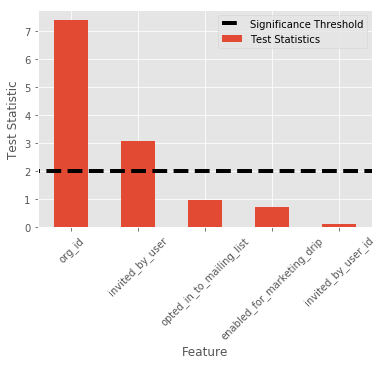

In [71]:
dfstat = dfstat.sort_values(by=0,ascending=False)
dfstat.rename(index=str, columns={0:'Test_Statistic'})
dfstat.plot(kind='bar')
plt.plot([-1,5],[2,2],'--',color='k',LineWidth=4)
plt.ylabel('Test Statistic')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.legend(['Significance Threshold','Test Statistics'])

<div class="span5 alert alert-success">
<p> Above, we see that the two columns with a statistically significant difference are "org_id" and "invited_by_user", with test statistics of 7.4 and 3.1, respectively. This means that with 95% confidence, we can say that the difference between adopted users and non-adopted users is significant, for both org_id and invited_by_user.

   </p>
</div>


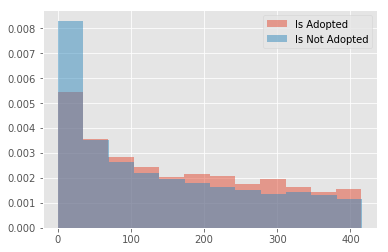

In [21]:
# Histogram of 'org_id', split by adopted vs. not-adopted groups
org1 = users.loc[users.is_adopted==1,'org_id']
org0 = users.loc[users.is_adopted==0,'org_id']
plt.hist(org1,alpha=0.5,density=True,bins=12)
plt.hist(org0,alpha=0.5,density=True,bins=12)
plt.legend(['Is Adopted','Is Not Adopted'])

<div class="span5 alert alert-success">
<p> Above, we see a histogram of 'org_id', split by adopted vs. not-adopted groups. Even though the difference between the groups is statistically significant, we can't make a prediction from the org_id alone. All we can say is that adopted users tend to have higher org_ids and are more likely to have been invited by a user.  

   </p>
</div>


In [63]:
# Independent variables for modeling
# Use OneHotEncoding to make categorical features into their own binary columns
encoder = ce.OneHotEncoder(cols=['creation_source'])
Xpre = users[['creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip','org_id','invited_by_user','is_adopted']]
# Dependent variable for modeling
y = users['is_adopted']
encoder.fit(Xpre, y)
X = encoder.transform(Xpre)

In [64]:
means = X.groupby('is_adopted').mean()
stds = X.groupby('is_adopted').std()
counts = X.groupby('is_adopted').count()

In [65]:
# Calculate test statistic for each column of creation_source
# Set significance level alpha = 0.05
tstats = {}
columns=['creation_source1','creation_source2','creation_source3','creation_source4','creation_source5']
for i in range(0,5):
    tstat = (means.iloc[0,i]-means.iloc[1,i])/(np.sqrt(stds.iloc[0,i]**2 / counts.iloc[0,i]  
                                                       + stds.iloc[1,i]**2 / counts.iloc[1,i] ))
    tmprow = encoder.category_mapping[0]['mapping'][i][0]
    tstats[tmprow] = [np.abs(tstat)]
dfstat = pd.DataFrame.from_dict(tstats).T
dfstat.rename(index=str, columns={0:'Test_Statistic'})

,Test_Statistic
GUEST_INVITE,4.537371
ORG_INVITE,0.725118
SIGNUP,0.961753
PERSONAL_PROJECTS,9.922317
SIGNUP_GOOGLE_AUTH,3.655822


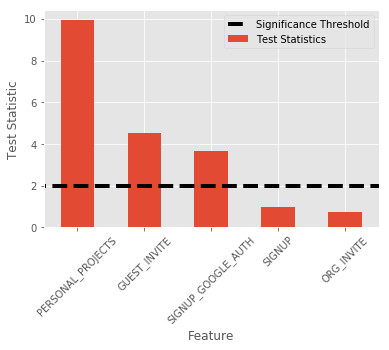

In [66]:
dfstat = dfstat.sort_values(by=0,ascending=False)
dfstat.rename(index=str, columns={0:'Test_Statistic'})
dfstat.plot(kind='bar')
plt.plot([-1,5],[2,2],'--',color='k',LineWidth=4)
plt.ylabel('Test Statistic')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.legend(['Significance Threshold','Test Statistics'])

In [25]:
X_creation = X.groupby('is_adopted').mean().iloc[:,0:5]
X_creation

,creation_source_1,creation_source_2,creation_source_3,creation_source_4,creation_source_5
is_adopted,,,,,
0,0.173434,0.355762,0.172564,0.187452,0.110789
1,0.222826,0.346618,0.182367,0.103865,0.144324


<div class="span5 alert alert-success">
<p> Above, I have again calculated test statistics, this time for the creation_source column. The values of creation_source that are statistically significant predictors of is_adopted are GUEST_INVITE, PERSONAL_PROJECTS, and SIGNUP_GOOGLE_AUTH. These all have a test statistic greater than 3. From these results, we can say that adopted users are more likely to originate from a GUEST_INVITE or SIGNUP_GOOGLE_AUTH, and less likely to originate from PERSONAL_PROJECTS.
   </p>
</div>


### Predictive Modeling

In [26]:
# Scale "org_id" to be between 0 and 1
users['org_id'] = (users['org_id'] - users['org_id'].min())/users['org_id'].max()

In [27]:
y.value_counts()

0    10344
1     1656
Name: is_adopted, dtype: int64

In [28]:
# Split into train and test sets
X = X.drop('is_adopted',axis=1)
Xtr, Xte, ytr, yte = TTS(X.values,y.values,random_state=5)

Best ROC AUC score =  0.5912871594145438
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=144,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
{'max_depth': 1, 'min_samples_split': 10, 'n_estimators': 144}
TRAINING SET
AUC =  0.5754659382563984
[[1655 6111]
 [ 136 1098]]
TEST SET
AUC =  0.5625820375837841
[[ 524 2054]
 [  47  375]]


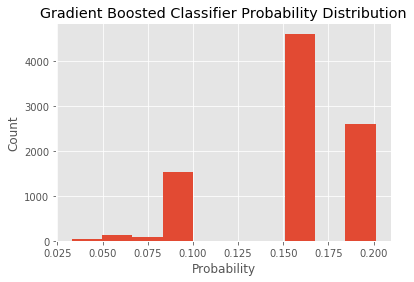

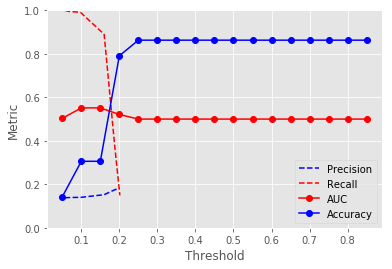

In [31]:
# Do RandomizedSearchCV to find optimal Gradient Boosted Classifier
from sklearn.ensemble import GradientBoostingClassifier as GBC
from scipy.stats import randint as sp_randint
direc = '/Users/Anthony/Documents/Bootcamp/relax_challenge/models/'
my_makedir(direc)
gbc = GBC() 
param_grid = {"max_depth": sp_randint(1, 20),
              "min_samples_split": sp_randint(2, 11),
              "n_estimators": sp_randint(50,200)}
filename = 'mod_gbc.p'
exists = os.path.isfile(direc+filename)
if exists:
    mod_gbc = pickle.load( open( direc+filename, "rb" ) )
else:
    mod_gbc = RSCV(estimator=gbc, param_distributions=param_grid, n_iter=20, cv=3,scoring='roc_auc',verbose=50)
    mod_gbc.fit(Xtr,ytr) 
    pickle.dump( mod_gbc, open( direc+filename, "wb" ) ) 
print('Best ROC AUC score = ',mod_gbc.best_score_)
print(mod_gbc.best_estimator_)
print(mod_gbc.best_params_)
get_metrics(mod_gbc.best_estimator_,Xtr,Xte,ytr,yte,thresh = 0.125)
mod = mod_gbc.best_estimator_
modprobs = mod.predict_proba(Xtr)
plt.hist(modprobs[:,1])
plt.title('Gradient Boosted Classifier Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.show()
y_pred = modprobs[:,1]
do_auc_prec_recall(ytr,y_pred,show_confusion=0)

Feature ranking:
1. feature 8: org_id (0.516183)
2. feature 3: creation_source_4 (0.339203)
3. feature 4: creation_source_5 (0.083920)
4. feature 0: creation_source_1 (0.060694)
5. feature 9: invited_by_user (0.000000)
6. feature 7: enabled_for_marketing_drip (0.000000)
7. feature 6: opted_in_to_mailing_list (0.000000)
8. feature 5: creation_source_-1 (0.000000)
9. feature 2: creation_source_3 (0.000000)
10. feature 1: creation_source_2 (0.000000)


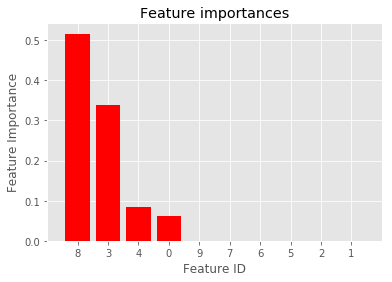

In [30]:
# Show which features are the most important
importances = mod.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(0,10):  # range(Xtr2.shape[1]):
    print("%d. feature %d: %s (%f)" % (f + 1, indices[f],X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1,10])
plt.xlabel('Feature ID')
plt.ylabel('Feature Importance')
plt.show()

<div class="span5 alert alert-success">
<p> I tested out a few predictive models from scikit-learn. Gradient Boosted Classification showed the best results, with a testing ROC AUC of 0.59. This value is only slightly higher than what you'd see from flipping a coin, so we shouldn't trust this model. The most important features, however, are still org_id and creation_source, which is a good sanity check against the previous statistical tests. 

   </p>
</div>


## Summary

<div class="span5 alert alert-success">
<p> Overall, the significance tests were the most insightful, while Gradient Boosted classification did not produce any decent models. Generally, we can say that adopted users tend to have higher org_ids and are more likely to have been invited by a user. And they are more likely to originate from a GUEST_INVITE or SIGNUP_GOOGLE_AUTH, and less likely to originate from PERSONAL_PROJECTS. 

   </p>
</div>
